In [1]:
import matplotlib.pyplot as plt
import mdtraj as md
import os, sys
import statistics as st
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
# Pyplot Setup
sns.set_theme(style="ticks", palette="pastel")
import matplotlib as mpl
plt.style.use(r'F:\DATA_F\JPCB_fig\publish.mplstyple')
def save_to_svg(filename, root_path='F:\DATA_F\JPCB_fig'):
    plt.savefig(os.path.join(root_path,filename))

In [3]:
# Main pandas dataframe schema
# Disorder table generate using lists
# Disordered region, Start, End, N terminal, C terminal, Length, Protein name, Species
# Protein raw data table
# Residue, Alphafold, location, Protein name, Disorder, Species
# Protein table
# Protein name, Species, N terminal, C terminal, Disorder
# Generate during group by function

In [4]:
# Protein raw data table
# Residue, Alphafold, location, Protein name, Disorder, Species
def load_data(species,path,filename='test_0504.csv'):
    """
    species:str
    path:str
    return dataframe
    """
    os.chdir(path)
    df=pd.read_csv('pdb_data_1214.csv')
    df['disorder']=df['alpha_fold_prediction']<50
    df['species']=species
    return df

In [5]:
#Pay attention when i is already changed

In [6]:
def N_ter_disorder_groupby(dataframe):
    beta=dataframe.sort_values(by=['location'],ascending=True)
    beta=beta.reset_index(drop=True)
    N_disordered=True
    folded=True
    for i in range(len(beta)):
        if beta.loc[i,'disorder']==False:
            break
    if i<30:
        N_disordered=False
    if N_disordered:
        for k in range(i,len(beta)):
            if beta.loc[k, 'disorder']==True:
                break
        if k-i<=30:
            folded=False
    length=i+1
    start=1
    end=length
    return N_disordered, length, start, end, folded

def C_ter_disorder_groupby(dataframe):
    beta=dataframe.sort_values(by=['location'],ascending=False)
    beta=beta.reset_index(drop=True)
    full_length=len(beta)
    C_disordered=True
    folded=True
    for i in range(len(beta)):
        if beta.loc[i,'disorder']==False:
            break
    if i<30:
        C_disordered=False
    if C_disordered:
        for k in range(i, len(beta)):
            if beta.loc[k, 'disorder']==True:
                break
        if k-i<=30:
            folded=False
    length=i+1
    start=full_length-length+1
    end=full_length
    return C_disordered, length, start, end, folded

In [7]:
def disordered_check_all_regions(dataframe):
    beta=dataframe.sort_values(by=['location'],ascending=True)
    beta=beta.reset_index(drop=True)
    any_disorder=False
    length=0
    maxlength=0
    length_list=[]
    for i in range(len(beta)):
        if beta.loc[i,'disorder']==False:
            maxlength=max(length,maxlength)
            if length>=30:
                end = i+1
                start = end - length +1
                length_list.append([length, start, end])
            length=0
        else:
            length+=1
    if maxlength >= 30:
        any_disorder=True
    return any_disorder, length_list

In [8]:
# Disorder table generate using lists
# Disordered region, Start, End, N terminal, C terminal, Length, Protein name, Species
def disorder_detection(dataframe,protein_name):
    """
    return a list with disordered information (Can be convert to Pandas)
    """
    result=[]
    N_ter, length, start, end, folded_N=N_ter_disorder_groupby(dataframe)
    if N_ter:
        result.append([protein_name[0]+'_N', start, end, True, False, length, protein_name[0], protein_name[1], folded_N])
    C_ter, length, start, end, folded_C=C_ter_disorder_groupby(dataframe)
    if C_ter:
        result.append([protein_name[0]+'_C', start, end, False, True, length, protein_name[0], protein_name[1], folded_C])
    disorder_mid, mid_list= disordered_check_all_regions(dataframe)
    if disorder_mid:
        for index, i in enumerate(mid_list):
            result.append([protein_name[0]+'_M_'+str(index), i[1], i[2], False, False, i[0], protein_name[0], protein_name[1], False])
    return pd.DataFrame(result,columns=['disordered region', 'start', 'end', 'N terminal',
                                        'C terminal', 'length', 'protein name', 'species','attach_folded'])
    
    
        

In [9]:
target_dir_dict={'Human':r'F:\alpha_human_fix','Yeast':r'F:\alpha_yeast','Arabidopsis':r'F:\alpha_arath'}

In [10]:
dfs=[]
for key,value in target_dir_dict.items():
    df=load_data(key, value)
    dfs.append(df)
full_df = pd.concat(dfs, axis=0)
full_df = full_df.reset_index(drop=True)

In [11]:
full_df

,residue,alpha_fold_prediction,location,protein_name,disorder,species
0,MET,59.87,1,A0A024R1R8,False,Human
1,SER,55.91,2,A0A024R1R8,False,Human
2,SER,62.74,3,A0A024R1R8,False,Human
3,HIS,59.86,4,A0A024R1R8,False,Human
4,GLU,61.56,5,A0A024R1R8,False,Human
...,...,...,...,...,...,...
28791242,TRP,69.45,825,X5JB51,False,Arabidopsis
28791243,PRO,60.38,826,X5JB51,False,Arabidopsis
28791244,SER,47.98,827,X5JB51,True,Arabidopsis
28791245,LEU,41.64,828,X5JB51,True,Arabidopsis


In [12]:
d_dfs=[]
grouped=full_df.groupby(['protein_name', 'species'])
for name, group in grouped:
    df=disorder_detection(group, name)
    d_dfs.append(df)
full_d_df=pd.concat(d_dfs)
full_d_df=full_d_df.reset_index(drop=True)

In [13]:
full_d_df.head()

,disordered region,start,end,N terminal,C terminal,length,protein name,species,attach_folded
0,A0A023PYF4_N,1,83,True,False,83,A0A023PYF4,Yeast,False
1,A0A023PYF4_C,83,145,False,True,63,A0A023PYF4,Yeast,False
2,A0A023PYF4_M_0,2,83,False,False,82,A0A023PYF4,Yeast,False
3,A0A023PZE8_C,97,133,False,True,37,A0A023PZE8,Yeast,False
4,A0A023PZG4_N,1,41,True,False,41,A0A023PZG4,Yeast,False


In [14]:
full_d_df['Mid region']=~full_d_df[['N terminal','C terminal']].any(axis='columns')

In [15]:
p_df=pd.DataFrame(list(grouped.groups),columns=['protein name','species'])

In [16]:
p_df['disorder']=p_df['protein name'].isin(full_d_df['protein name'])
p_df['Mid region']=p_df['protein name'].isin(full_d_df.loc[full_d_df['Mid region']]['protein name'])
p_df['N terminal']=p_df['protein name'].isin(full_d_df.loc[full_d_df['N terminal']]['protein name'])
p_df['C terminal']=p_df['protein name'].isin(full_d_df.loc[full_d_df['C terminal']]['protein name'])

In [17]:
p_df['N terminal_tethered']=p_df['protein name'].isin(full_d_df.loc[full_d_df['N terminal']&full_d_df['attach_folded']]['protein name'])
p_df['C terminal_tethered']=p_df['protein name'].isin(full_d_df.loc[full_d_df['C terminal']&full_d_df['attach_folded']]['protein name'])

In [18]:
p_df[p_df['species']=='Human'].count()

protein name           20504
species                20504
disorder               20504
Mid region             20504
N terminal             20504
C terminal             20504
N terminal_tethered    20504
C terminal_tethered    20504
dtype: int64

In [19]:
p_df[(p_df['species']=='Human')&(p_df['N terminal_tethered'])].count()

protein name           1835
species                1835
disorder               1835
Mid region             1835
N terminal             1835
C terminal             1835
N terminal_tethered    1835
C terminal_tethered    1835
dtype: int64

In [20]:
p_df[(p_df['species']=='Human')&(p_df['C terminal_tethered'])].count()

protein name           1026
species                1026
disorder               1026
Mid region             1026
N terminal             1026
C terminal             1026
N terminal_tethered    1026
C terminal_tethered    1026
dtype: int64

In [21]:
df_list=[]
for key,value in target_dir_dict.items():
    sub_df=p_df.loc[p_df['species']==key]
    print(sub_df.head())
    total_protein=sub_df.count()['protein name']
    N_ter_protein=sub_df[sub_df['N terminal']].count()['protein name']
    C_ter_protein=sub_df[sub_df['C terminal']].count()['protein name']
    N_ter_protein_t=sub_df[sub_df['N terminal_tethered']].count()['protein name']
    C_ter_protein_t=sub_df[sub_df['C terminal_tethered']].count()['protein name']
    Mid_protein=sub_df[sub_df['Mid region']& (~sub_df['N terminal']) & (~sub_df['C terminal'])].count()['protein name']
    both_protein=sub_df[sub_df['Mid region']&(sub_df['N terminal']|sub_df['C terminal'])].count()['protein name']
    C_N=sub_df[sub_df['N terminal']|sub_df['C terminal']].count()['protein name']
    C_N_t=sub_df[sub_df['N terminal_tethered']|sub_df['C terminal_tethered']].count()['protein name']
    one_disorder=sub_df[sub_df['disorder']].count()['protein name']
    df_list.append([key,N_ter_protein/total_protein,'N-terminal disordered region'])
    df_list.append([key,C_ter_protein/total_protein,'C-terminal disordered region'])
    df_list.append([key,N_ter_protein_t/total_protein,'N-terminal disordered tethered'])
    df_list.append([key,C_ter_protein_t/total_protein,'C-terminal disordered tethered'])
    df_list.append([key,C_N/total_protein,'At least one terminal disordered region'])
    df_list.append([key,C_N_t/total_protein,'At least one terminal disordered tethered'])
    df_list.append([key,Mid_protein/total_protein, 'Middle disordered region Only'])
    df_list.append([key,one_disorder/total_protein, 'At least one disordered region'])
#name_plot=['name','N-terminal disordered propensity','C-terminal disordered propensity','C+N propensity(At least one)']
#df_plot=pd.DataFrame(bar_3_list,columns=name_plot)
df_plot=pd.DataFrame(df_list,columns=['Species','Value','Type'])

  protein name species  disorder  Mid region  N terminal  C terminal  \
5   A0A024R1R8   Human     False       False       False       False   
6   A0A024RBG1   Human     False       False       False       False   
7   A0A024RCN7   Human     False       False       False       False   
8   A0A075B6H5   Human     False       False       False       False   
9   A0A075B6H7   Human     False       False       False       False   

   N terminal_tethered  C terminal_tethered  
5                False                False  
6                False                False  
7                False                False  
8                False                False  
9                False                False  
  protein name species  disorder  Mid region  N terminal  C terminal  \
0   A0A023PYF4   Yeast      True        True        True        True   
1   A0A023PZB3   Yeast     False       False       False       False   
2   A0A023PZE8   Yeast      True       False       False        True   
3  

In [22]:
df_plot

,Species,Value,Type
0,Human,0.157677,N-terminal disordered region
1,Human,0.110076,C-terminal disordered region
2,Human,0.089495,N-terminal disordered tethered
3,Human,0.050039,C-terminal disordered tethered
4,Human,0.237173,At least one terminal disordered region
5,Human,0.131340,At least one terminal disordered tethered
6,Human,0.279067,Middle disordered region Only
7,Human,0.516241,At least one disordered region
8,Yeast,0.167550,N-terminal disordered region
9,Yeast,0.090563,C-terminal disordered region


## Convert to percentage

In [23]:
if df_plot['Value'][0]<1:
    df_plot['Value']=df_plot['Value']*100
df_plot

,Species,Value,Type
0,Human,15.767655,N-terminal disordered region
1,Human,11.007608,C-terminal disordered region
2,Human,8.949473,N-terminal disordered tethered
3,Human,5.003902,C-terminal disordered tethered
4,Human,23.717323,At least one terminal disordered region
5,Human,13.134023,At least one terminal disordered tethered
6,Human,27.906750,Middle disordered region Only
7,Human,51.624073,At least one disordered region
8,Yeast,16.754967,N-terminal disordered region
9,Yeast,9.056291,C-terminal disordered region


In [24]:
target_list=['At least one disordered region','At least one terminal disordered region']

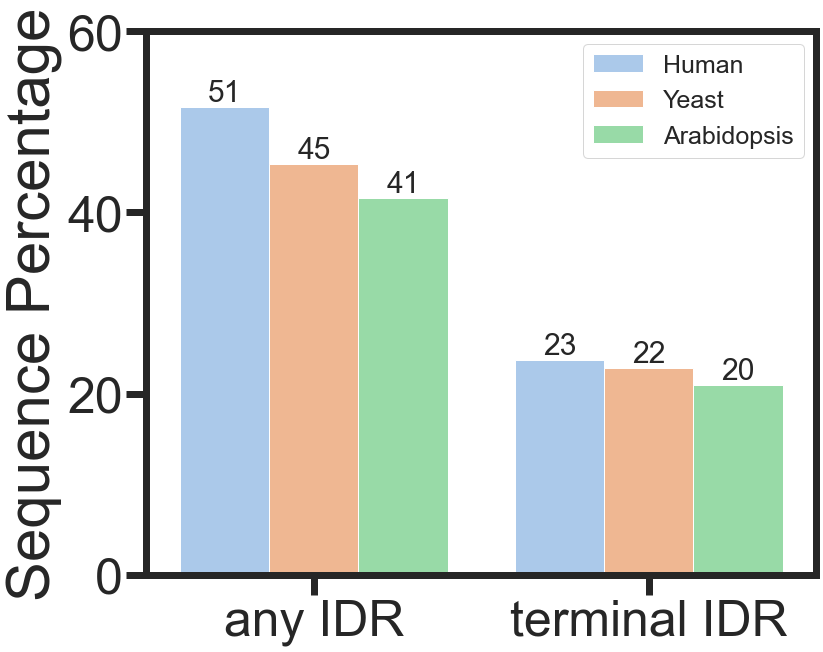

In [25]:
import seaborn as sns
sns.set_theme(style="ticks", palette="pastel")
import matplotlib as mpl
plt.style.use(r'F:\DATA_F\JPCB_fig\publish.mplstyple')
fig = plt.figure(figsize=(12,10))
g = sns.barplot(x="Type", y="Value", hue="Species",data=df_plot[df_plot['Type'].isin(target_list)],order=target_list) 
for i in g.containers:
    g.bar_label(i,fmt='%d',fontsize=30)
g.set_xticks([0,1],['any IDR','terminal IDR'])
g.legend(fontsize=25)
plt.ylim(0,60)
plt.ylabel('Sequence Percentage')
plt.xlabel('')
os.chdir('F:\DATA_F\JPCB_fig')
#plt.savefig('Fig1C.svg')

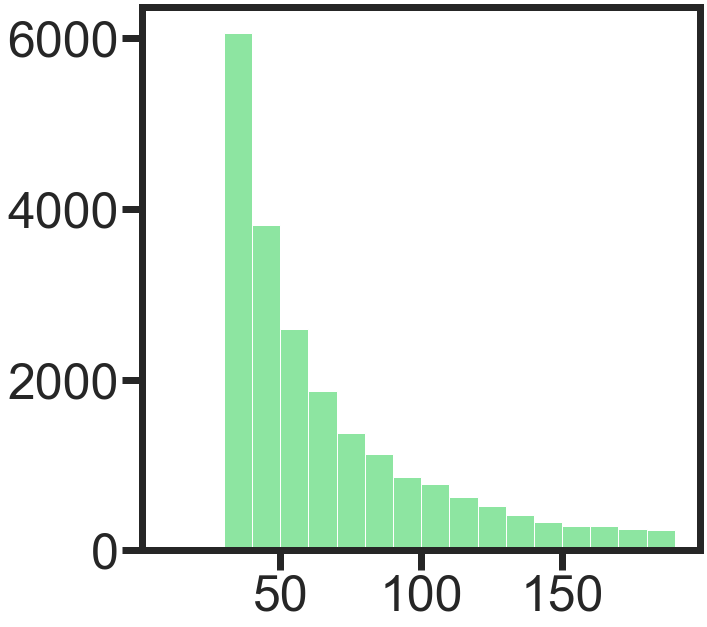

In [31]:
bins_a=list(range(10,200,10))

C_ter_length=full_d_df[(full_d_df['species']=='Human')&(full_d_df['C terminal'])]['length']
N_ter_length=full_d_df[(full_d_df['species']=='Human')&(full_d_df['N terminal'])]['length']
mid_region=full_d_df[(full_d_df['species']=='Human')&(full_d_df['Mid region'])]['length']

N=plt.hist(N_ter_length,bins=bins_a)
C=plt.hist(C_ter_length,bins=bins_a)
mid=plt.hist(mid_region,bins=bins_a)

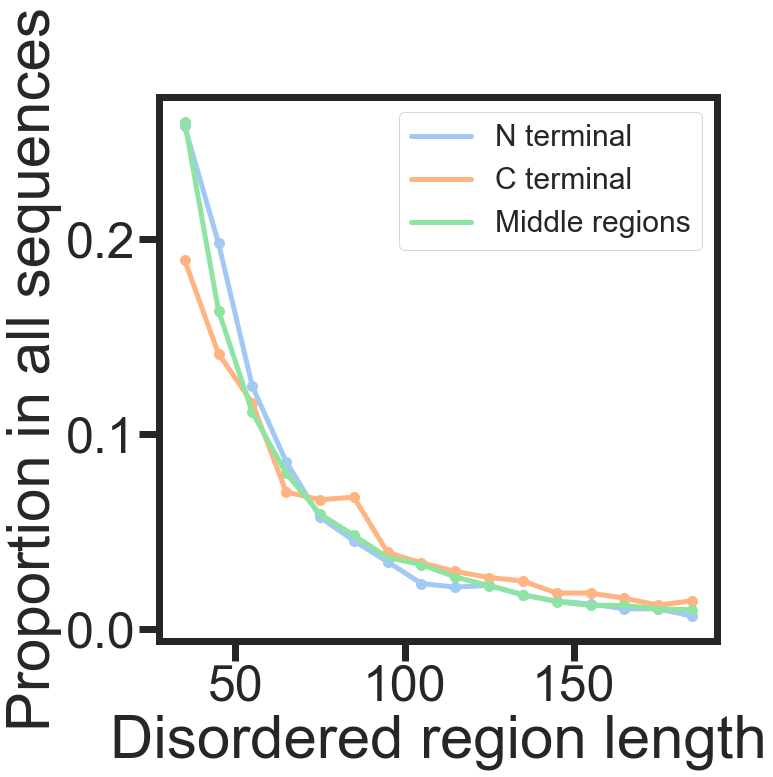

In [32]:
N_y=N[0]/N_ter_length.count()
C_y=C[0]/C_ter_length.count()
mid_y=mid[0]/mid_region.count()

x=(N[1][:-1]+N[1][1:])/2

plt.plot(x[2:],N_y[2:],label='N terminal')
plt.scatter(x[2:],N_y[2:])
plt.plot(x[2:],C_y[2:],label='C terminal')
plt.scatter(x[2:],C_y[2:])
plt.plot(x[2:],mid_y[2:],label='Middle regions')
plt.scatter(x[2:],mid_y[2:])
plt.ylabel('Proportion in all sequences')
plt.xlabel('Disordered region length')
plt.legend()
#plt.title('Human', fontsize=40)
#save_to_svg('Fig1D.svg')